In [78]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice, MockDevice, DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import matplotlib as mpl
from matplotlib.patches import Rectangle


# 2. State preparation of Rydberg crystals

In this section, we design a pulse to prepare the ground state of a chain of atoms subject to different blockade radius. The blockade radius $R_b$ is tuned by $\Omega_{max}$ following $R_b = (C_6/\Omega_{max})^{1/6}$. We also want to tune the detuning applied on the atoms - large final detuning $\delta_T$ forces the occupation of excited Rydberg states (while subject to the blockade phenomena), while small to non-existent detuning will leave the state in the $|000...0\rangle$ state. In general, the phase diagram we can expect is given by:

<center><img src="../images/phasediagram.png" width="1200"/></center>

Our first task is to prepare the $Z_2, Z_3, ...$ states on a linear chain. These states are on the far right of this graph. 

Later on in the section, we will tune the final detuning $\delta_T = \alpha \delta_{max}$ of the pulse to move on the red dotted lines and probe the quantum phase transition from the disordered to the ordered $Z_N$ state, thus preparing ground states of the quantum hamilonian

$$ \frac{\mathcal{H}}{\hbar} = \sum_i ( \Omega_{max} \sigma_i^x - \alpha \delta_{max} n_i  + \sum_{j<i} \frac{C_6}{r_{ij}^6} n_i n_j )$$



We first start by creating a register for a 1D chain with open boundary conditions. 

We can tune the atomic separation $a$ and the blockade radius $R_b$ so as to engineer different $Z_N$ phases. In order to realize blockaded $Z_N$ phases, we tune the parameter `periodicity` which is really $N+1$. For best results, make sure that the $Z_N$ pattern you are trying to realize is commensurate with the size of the chain. For example, for a $Z_3$ phase, you could have $N_{atoms} = 4,7,10,...$. You can check that the parameters you've put are consistent by checking that the N of $Z_N$ crystal is $N = \lceil R_b/a \rceil + 1$.

Blockade Radius is: 8.692279598222772µm.
Interatomic distance is: 5.0µm.
Omega max is: 12.566370614359172 rad/us.
Ratio R_b/a is: 1.7384559196445544µm. 


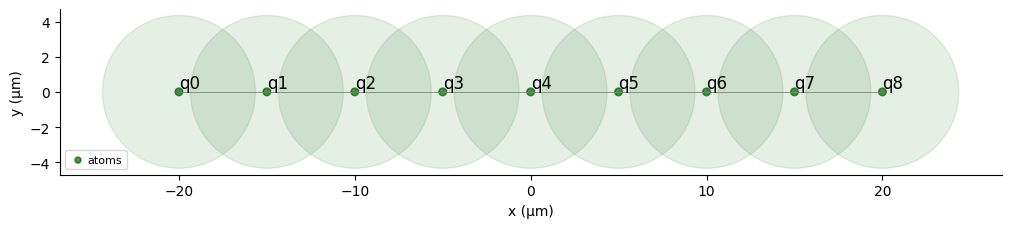

In [57]:
device_used = MockDevice #a simple virtual device
periodicity = 2 
#distance between atoms
a = 5.0 #keep a = 5.0, except for periodicity=4, try a = 4.0

#number of atoms in chain: for periodicity = 2, try N=9, 
# for periodicity = 3, try N=10, for periodicity = 4, try N=9
N_atoms = 9 
#the blockade radius has to cover a certain number of sites
R_blockade= (periodicity - 1)*1.02*a #we want to set the blockade radius at this

#find the corresponding Omega_max for this R_blockade 
#note that we restrict Omega_max to not be larger than 2*2*np.pi
# that is the max allowed Rabi amplitude on real QPUs 
Omega_max = min(device_used.rabi_from_blockade(R_blockade), 2 * 2 * np.pi) #we may be limited by the max Omega achievable on the device
#rederive the final R_blockade
R_blockade = device_used.rydberg_blockade_radius(Omega_max)

#define a Register of N_atoms in a line
reg = Register.rectangle(1, N_atoms, spacing=a, prefix="q")
print(f"Blockade Radius is: {R_blockade}µm.")
print(f"Interatomic distance is: {a}µm.")
print(f"Omega max is: {Omega_max} rad/us.")
print(f"Ratio R_b/a is: {R_blockade/a}µm. ")

reg.draw(blockade_radius=R_blockade, draw_half_radius=True)


Then, we create a quantm annealing pulse to prepare the ground state. Here, we want to take the system from the the known state $|0000...\rangle$ at $t=0$ to the ground state of the simulated hamiltonian at $t=T$. To do so, we continuously alter the Hamiltonian's parameters in time, and create a path that is inspired by the quantum adiabatic algorithm.

We know the pulse design needs to have
- $t=0$:    $\delta (t=0) = \delta_0 < 0$, $\Omega (t=0) = 0$ - initial state is $|0000...\rangle$;
- $t=T/2$:     $\delta (t=T/2) = 0$, $\Omega (t=T/2) = \Omega_{max}$ - we apply $\Omega_{max}$ to enforce the Rydberg blockade constraints;
- $t=T$:   $\delta (t=T) = \delta_f > 0$, $\Omega (t=T) = 0$ - final state maximizes the number of Rydberg excitations.

We set $\delta_0 = \delta_f = 2*\Omega_{max}$, and design a heuristic rise - sweep - fall pulse, as you can see below. The duration of each section can be adjusted. Once you've completed the section, we recommend you play with those to get a sense of what could be the optimal parameters to design your analog state preparation routine with the highest fidelity. In general, you can also implement more general parametrized pulses and optimize the parameters as you would in a QAOA algorithm. 

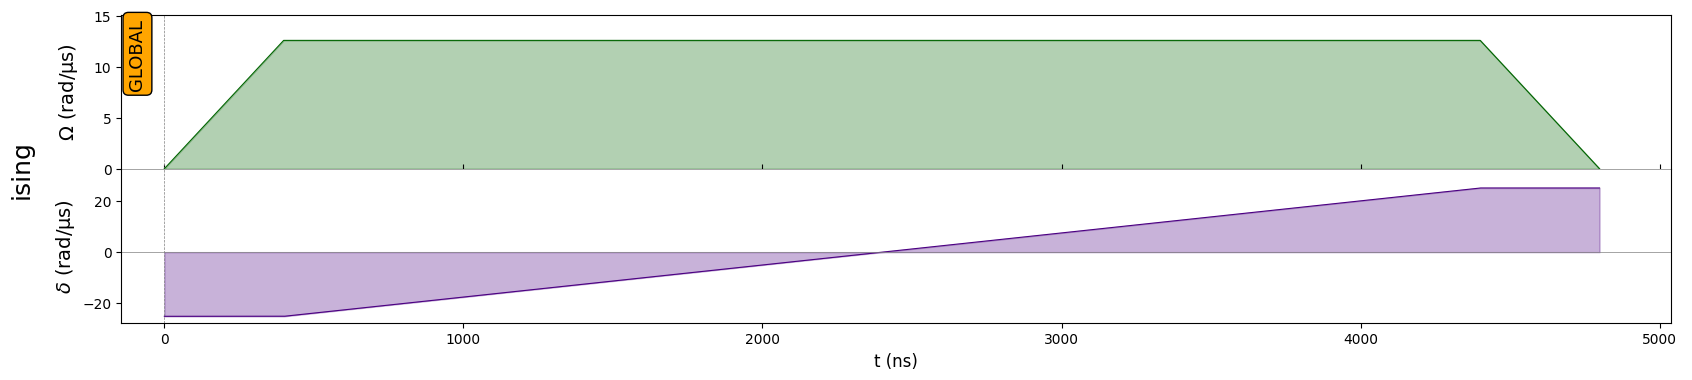

In [58]:
#detuning values
U = 2*Omega_max
delta_0 = -1.0 * U
delta_f = 1.0 * U
#rise, sweep, fall times: these times are in ns
t_rise = 400 
t_sweep = 4000
t_fall = 400
#create the pulse shapes
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

#create the sequence
seq = Sequence(reg, MockDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

Next, we run an "experiment" using this pulse and register. This is done through the `QutipEmulator` object, which performs a statevector emulation. The final results is stored in the `results` object.

An example of a noiseless and noisy noise configuration is shown, so that you may try the effects of reasonable noise on the simulation. **Careful!** Running a noisy simulation can take quite longer!

In [59]:
noise_config = {'noiseless': None, 
                'noisy': SimConfig(
    noise=("SPAM", "dephasing", "doppler"),
    epsilon=0.01, #false positive
    epsilon_prime=0.05, #false negatives
    eta=0.005, #badly prepared initial state
    temperature=1000,
    runs=50,) 
}

simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    config=noise_config['noiseless'])
simul.show_config()
results = simul.run(progress_bar=True)


Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.48s. Est. time left: 00:00:00:01
40.0%. Run time:   0.64s. Est. time left: 00:00:00:00
50.0%. Run time:   0.80s. Est. time left: 00:00:00:00
60.0%. Run time:   0.99s. Est. time left: 00:00:00:00
70.0%. Run time:   1.18s. Est. time left: 00:00:00:00
80.0%. Run time:   1.38s. Est. time left: 00:00:00:00
90.0%. Run time:   1.61s. Est. time left: 00:00:00:00
Total run time:   1.84s


Select a number of samples (a.k.a shots), and sample the results of the Qutip backend simulation. This will return a Counter of bitstrings and how many times they were obtained. In these bitstrings, a `0` corresponds to an atom in the ground state, while a `1` is an atom in the Rydberg state - this is the $n_i$ Rydberg occupation basis.

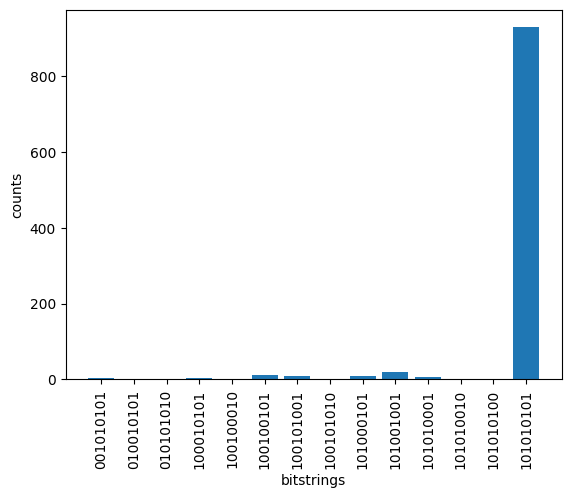

In [61]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
#we filter the counts to show only states seen more than threshold of the time.
threshold = 0.0*N_samples #no threshold
# threshold = 0.05*N_samples #5% threshold
most_freq = {k: v for k, v in count_dict.items() if v > threshold} 
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

We then plot the average Rydberg occupation of each site $\langle n_i \rangle$, which is obtained by counting the contribution of each bitstring. This is collected in `avg_occupation`

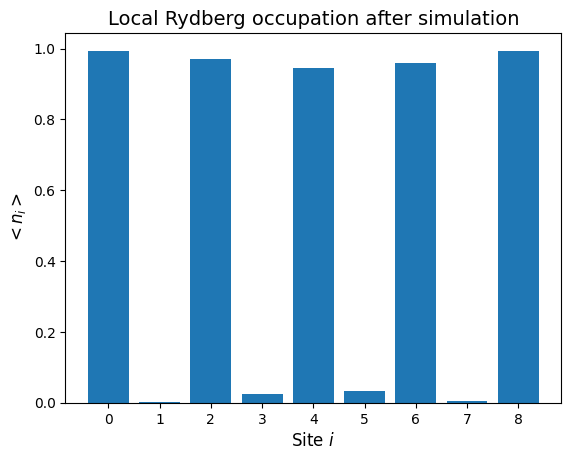

In [62]:
avg_occupation = np.zeros(N_atoms)
for key_str, count in count_dict.items():
    for i in range(N_atoms):
        if key_str[i] == '1':
            avg_occupation[i] += count
values = np.array(avg_occupation/N_samples)
plt.bar(x = range(N_atoms), height=values)
plt.xticks(
    range(values.shape[0]), ["{}".format(i) for i in range(N_atoms)]
)
plt.title(r"Local Rydberg occupation after simulation", fontsize=14)
plt.xlabel(r"Site $i$", fontsize=12)
plt.ylabel(r"$<n_i>$", fontsize=12)
# plt.ylim([-ylim, ylim])
plt.show()

## Probing the quantum phase transition

In order to prepare this state, we had to go through a phase transition between a known state $|000...0\rangle$ and the ground state of the atomic chain, as was shown in the phase diagram at the beginning of the section. We can probe this phase transition by using the same register, but changing the parameters of the pulse. We will then reiterate the register creation code, and then create a function called `prepare_at_given_detuning` that takes a parameter `alpha` and corresponds to the pulse needed to simulate the Hamiltonian 

$$ \frac{\mathcal{H}}{\hbar} = \sum_i ( \Omega_{max} \sigma_i^x - \alpha \delta_{max} n_i  + \sum_{j<i} \frac{C_6}{r_{ij}^6} n_i n_j )$$

This new pulse is like our original pulse, but we tune the final detuning $\delta_T = \alpha \delta_{max}$.

Note that this section works best for the $Z_2$ state.

In [63]:
a = 5.0
periodicity = 2 
N_atoms = 9 #number of atoms in chain
R_blockade= (periodicity - 1)*1.05*a
Omega_max = min(device_used.rabi_from_blockade(R_blockade), 2 * 2 * np.pi)
R_blockade = device_used.rydberg_blockade_radius(Omega_max)

reg = Register.rectangle(1, N_atoms, spacing=a, prefix="q")


def prepare_at_given_detuning(alpha):
    U = 2*Omega_max
    delta_0 = -1.0 * U
    delta_f = 1.0 * U
    #these times are in ns
    t_rise = 800
    t_sweep = 4000
    t_fall = 800
    delta_f_alt = alpha*delta_f

    rise = Pulse.ConstantDetuning(
        RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
    )


    sweep_1 = Pulse.ConstantAmplitude(
        Omega_max, RampWaveform(t_sweep/2, delta_0, 0), 0.0
    )
    sweep_2 = Pulse.ConstantAmplitude(
        Omega_max, RampWaveform(t_sweep/2, 0, delta_f_alt), 0.0
    )
    seq = Sequence(reg, device_used)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(rise, "ising", "no-delay")
    seq.add(sweep_1, "ising", "no-delay")
    seq.add(sweep_2, "ising", "no-delay")
    fall = Pulse.ConstantDetuning(
        RampWaveform(t_fall, Omega_max, 0.0), delta_f_alt, 0.0
    )
    seq.add(fall, "ising", "no-delay")
    
    return seq

Show a given sequence for $\alpha = 0.5$

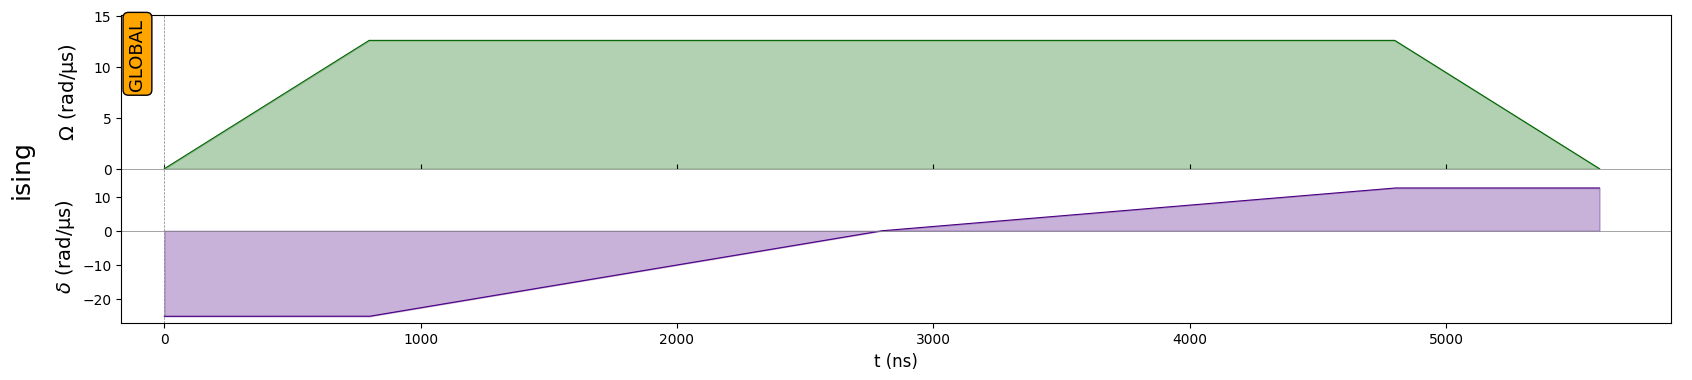

In [67]:
seq = prepare_at_given_detuning(alpha = 0.5)
seq.draw()

Perform the emulation.

In [68]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    config=noise_config['noiseless'])
simul.show_config()
results = simul.run(progress_bar=True)


Options:
----------
Number of runs:        15
Samples per run:       5
10.0%. Run time:   0.16s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.49s. Est. time left: 00:00:00:01
40.0%. Run time:   0.66s. Est. time left: 00:00:00:00
50.0%. Run time:   0.87s. Est. time left: 00:00:00:00
60.0%. Run time:   1.09s. Est. time left: 00:00:00:00
70.0%. Run time:   1.31s. Est. time left: 00:00:00:00
80.0%. Run time:   1.54s. Est. time left: 00:00:00:00
90.0%. Run time:   1.80s. Est. time left: 00:00:00:00
Total run time:   2.05s


Show the bitstring distribution for this run.

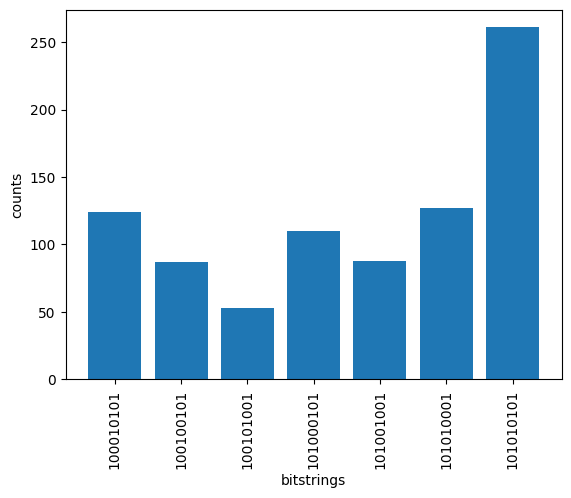

In [73]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
#we filter the counts to show only states seen more than threshold of the time.
# threshold = 0.0*N_samples #no threshold
threshold = 0.05*N_samples #5% threshold
most_freq = {k: v for k, v in count_dict.items() if v > threshold} 
plt.bar(list(most_freq.keys()), list(most_freq.values()))
plt.xticks(rotation="vertical")
plt.ylabel('counts')
plt.xlabel('bitstrings')
plt.show()

Again, we show the average Rydberg occupation per site. Note that, for $\alpha = 0.5$, the $Z_2$ pattern is not as clear - it has started to melt.

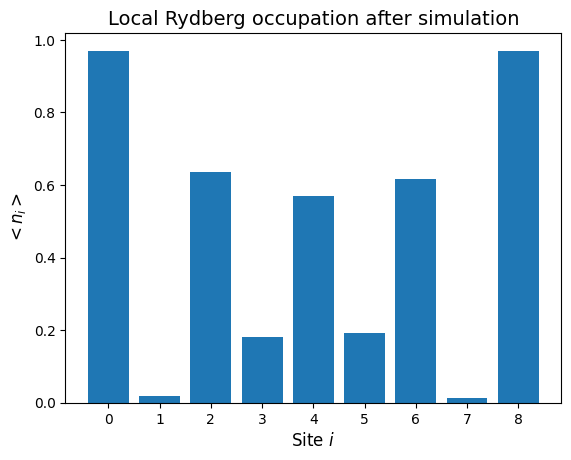

In [74]:
N_samples = 1000
count_dict = results.sample_final_state(N_samples=N_samples)
avg_occupation = np.zeros(N_atoms)
for key_str, count in count_dict.items():
    for i in range(N_atoms):
        if key_str[i] == '1':
            avg_occupation[i] += count
values = np.array(avg_occupation/N_samples)
plt.bar(x = range(N_atoms), height=values)
plt.xticks(
    range(values.shape[0]), ["{}".format(i) for i in range(N_atoms)]
)
plt.title(r"Local Rydberg occupation after simulation", fontsize=14)
plt.xlabel(r"Site $i$", fontsize=12)
plt.ylabel(r"$<n_i>$", fontsize=12)
# plt.ylim([-ylim, ylim])
plt.show()

We compare the average of $m_2 = \langle \frac{1}{N} \sum_i (-1)^i (2*n_i - 1) \rangle$ as we tune $\alpha$. In a perfect $Z_2$ crystal, we have $m_2 = 1$, while in a disordered state, it will tend to zero. This is called the order parameter. This cell can take up to 1 minute to run, depending on your computer.


In [76]:
alphas = np.linspace(0.0, 1.0, 15)
data = np.zeros(len(alphas))
for n in range(len(alphas)):
    seq = prepare_at_given_detuning(alpha = alphas[n])
    simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=0.5, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real device
                                    )
    results = simul.run(progress_bar=False)
    N_samples = 1000
    count_dict = results.sample_final_state(N_samples=N_samples)
    Z_2_occupation = np.zeros(N)
    for key_str, count in count_dict.items():
        for i in range(N):
            if key_str[i] == '1':
                Z_2_occupation[i] += (-1)**i * count 
            else:
                Z_2_occupation[i] += -(-1)**i * count
    data[n] = np.mean(Z_2_occupation/N_samples)


We then plot $m_2$ versus $\alpha$.

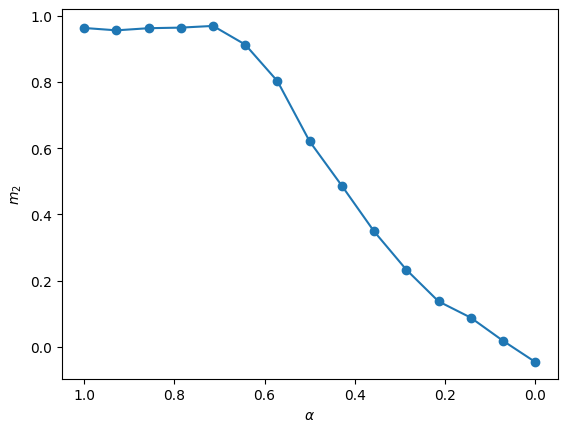

In [77]:
plt.plot(alphas, data, 'o-')
plt.gca().invert_xaxis()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$m_2$');

We can see that for this small chain, the overlap to the $Z_2$ state (measured here through $m_2$) is reduced for small $\alpha$. This is because smaller $\alpha$ correspond to the state preparation of a state with weak final detuning which is unable to force atoms in the excited state, and thus the states tend to $|000...0\rangle$.

You can try to create other measurements for the $Z_3$, $Z_4$ states, and play with other pulse shapes in the state preparation/quantum simulation of the chain of atoms.

# 4. Mapping the MIS problem on neutral atoms.

In this section, we embed a graph combinatorial optimization problem on an interacting system of neutral atoms, and then we perform a quantum annealing rise - sweep - fall pulse to sample the ground state. The problem we will be concerned with is the maximum independent set (MIS) problem, which is defined on a graph $G = (V,E)$, and consists of solving the following problem:

$$ \max \sum_{i \in V} n_i, \\ \text{s.t.} \; n_i + n_j \leq 1 \forall (i,j) \in E, \\ n_i \in \{0,1\}$$

In plain words, a MIS consists in chosing the largest set of nodes so that no two nodes share an edge with one another. For small graphs, you may be able to deduce the answer yourself, but for large graphs, even good classical solvers start to take a long time to generate a solution - this is a NP-Hard problem.

In the following cell, we use the `networkx` library to 1) generate a random Erdos-Renyi graph, 2) find positions for the nodes in the 2D plane using the `spring_layout` function and 3) draw the graph.

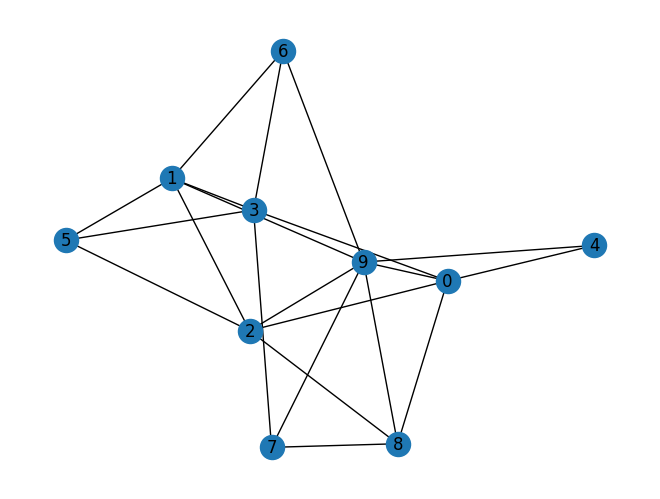

In [95]:
seed = 42
N = 10 #number of sites
#create a random graph. p is the density of edges
graph = nx.erdos_renyi_graph(n = N, p = 0.5, seed = seed)
#we use spring layout's Fruchterman-Reingold algorithm to get a preliminary position of the nodes
#this treats every edges as an "elastic" and finds the equilibrium positions for all the forces.
pos = nx.spring_layout(graph, k = 0.1, dim=2)
#draw the graph
nx.draw(graph, pos = pos)
nx.draw_networkx_labels(graph, pos = pos);

We then use Networkx's heuristic algorithms to find a maximum independent set on this graph.

In [96]:
ind_set = nx.approximation.maximum_independent_set(graph)
print(f'Heuristic: MIS sol is {ind_set}')
nil_string = np.zeros(len(graph), dtype=int) 
for k in ind_set:
    nil_string[k] = 1
ind_set_bitstring = ''.join([str(nil_string[i]) for i in range(len(graph))])
print(f'Heuristic: MIS bitstring is {ind_set_bitstring}')


Heuristic: MIS sol is {2, 3, 4}
Heuristic: MIS bitstring is 0011100000


We then define the register in which we'd like to embed the problem. For this purpose, we use the positions obtained from the `spring_layout` function, and rescale then so that the minimal distance between "atoms" is $4\mu m$. We then calculate the interaction matrix between all the atoms, and use the median non-zero value of the interaction matrix to help use find the right $\Omega_{max}$ for this graph. Note that this procedure is heuristic. It works well in this case, but finding a general recipe for the right $\Omega_{max}$ for a given graph $G$ and its atomic embedding remains a research subject.

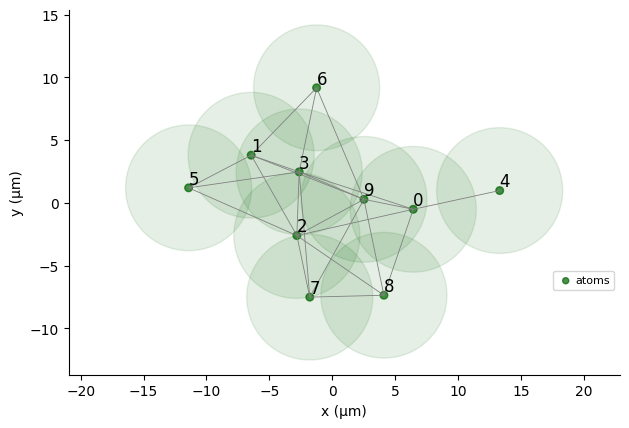

In [97]:
coords = np.array(list(pos.values())) #extract coordinates from the spring layout
val = np.min(pdist(coords))
coords *= 4/val #make sure the minimum distance is 4 um - rescale the register

#extract the corresponding interaction matrix
int_matrix = squareform(device_used.interaction_coeff / pdist(coords) ** 6) #extract the corresponding interaction matrix
Omega_max = np.median(int_matrix[int_matrix > 0].flatten())
R_blockade = device_used.rydberg_blockade_radius(Omega_max)
delta_0 = -Omega_max  # just has to be negative
delta_f = -delta_0  # just has to be positive

#create a register
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=R_blockade,
    draw_graph=True,
    draw_half_radius=True,
)

Compare the blockade graph (i.e. which atoms are blockaded by which other) with the initial graph's adjacency matrix.

/tmp/ipykernel_11962/1264095683.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_theory = nx.adjacency_matrix(graph).toarray()


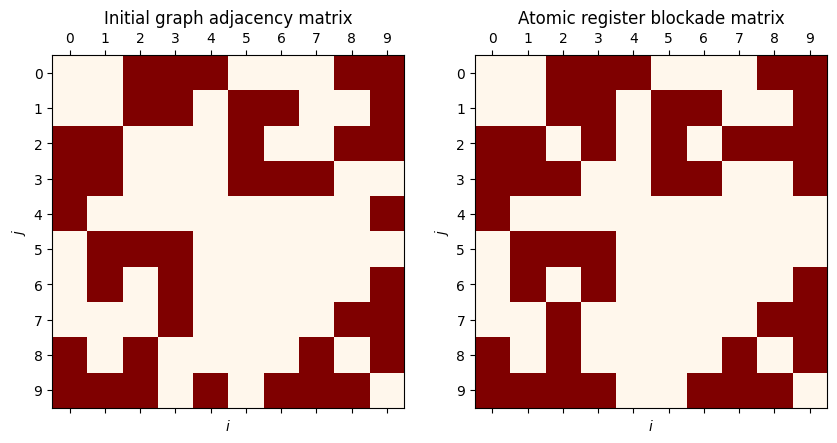

In [98]:
mat_coords = squareform(pdist(coords))
adj_reg = 1.0*(mat_coords < R_blockade)
for i in range(N):
    adj_reg[i,i] = 0
adj_theory = nx.adjacency_matrix(graph).toarray()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
cmap = plt.get_cmap('OrRd')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

plot_Q = [adj_theory, adj_reg]
titles = ['Initial graph adjacency matrix', 'Atomic register blockade matrix']
k = 0
for ax in axes.flat:

    # Q_plot = plot_Q[k]/np.max(plot_Q[k])
    Q_plot = plot_Q[k]
    norm = mpl.colors.Normalize(vmin=np.min(Q_plot), vmax=np.max(Q_plot))

    img = ax.matshow(Q_plot, cmap=cmap)
    # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set_xticks(np.arange(len(Q_plot)))
    ax.set_yticks(np.arange(len(Q_plot)))
    ax.set_xlabel(r'$i$')
    ax.set_ylabel(r'$j$')
    ax.set_title(titles[k])
    k += 1

plt.show()

We see that they are not quite the same, but that the overlap is good. If one wanted to pursue a more general algorithm to improve the embedding, one could design a variational loop where one alters the maximum Rabi ampitude (which controls the blockade radius) and the placement of the atoms so that the difference between these two matrices is minimal. This loop is entirely classical, and serves to improve the embedding process prior to sending the Register and Sequence to the QPU.

We then perform a rise - sweep - fall annealing pulse.

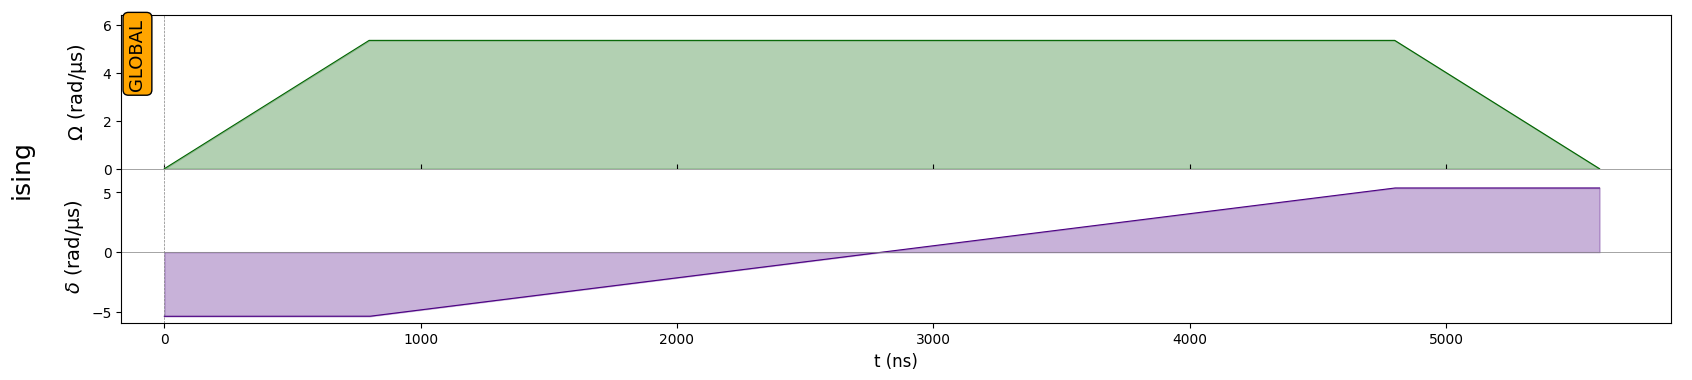

In [99]:
#these times are in ns
t_rise = 800
t_sweep = 4000
t_fall = 800
rise = Pulse.ConstantDetuning(
    RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = Pulse.ConstantAmplitude(
    Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = Pulse.ConstantDetuning(
    RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

We emulate the result of this Sequence.

In [100]:
simul = QutipEmulator.from_sequence(seq, #sequence to simulate
                                    sampling_rate=1, #change the sampling of the wavefunction
                                    with_modulation=False, #modulate the signal like a real devic
                                    )
results = simul.run(progress_bar=True)


10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.71s. Est. time left: 00:00:00:02
30.0%. Run time:   1.10s. Est. time left: 00:00:00:02
40.0%. Run time:   1.51s. Est. time left: 00:00:00:02
50.0%. Run time:   1.93s. Est. time left: 00:00:00:01
60.0%. Run time:   2.42s. Est. time left: 00:00:00:01
70.0%. Run time:   2.89s. Est. time left: 00:00:00:01
80.0%. Run time:   3.37s. Est. time left: 00:00:00:00
90.0%. Run time:   3.87s. Est. time left: 00:00:00:00
Total run time:   4.30s


We define some functions to extract information and process the cost of given bitstrings with respect to the MIS problem.

In [101]:
#sum the bits in a given bitstring
def sum_bit(string_in):
    list_b = [int(string_in[i]) for i in range(len(string_in))]
    return np.sum(list_b)

#check if a given bitstring is an independent set, i.e. no two nodes on an edge are selected
def check_IS(key_string, graph):
    state = [int(key_string[k]) for k in range(len(key_string))]
    bool_val = True
    for ed in graph.edges():
        val = (state[int(ed[0])] + state[int(ed[1])])
        if val == 2:
            bool_val = False
    return bool_val

We then plot the bitstring distribution, and color the bars wether they are a) better than the heuristic Networkx MIS solution, b) as good as the heuristic Networkx solution, c) an independent set of less good quality than the MIS d) not an independent set at all. Note that the heuristic method from Networkx only gives one solution, and we find many degenerate solutions (different bitstrings with the same cost).

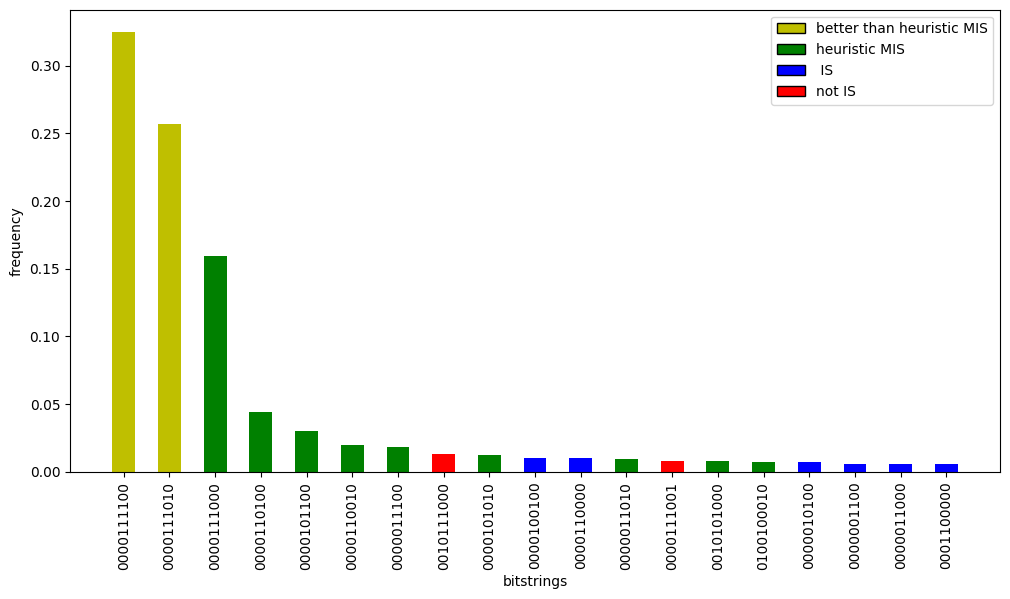

In [102]:
N_samples = 2000
count_dict = results.sample_final_state(N_samples=N_samples)
most_freq = {k: v/N_samples for k, v in count_dict.items() if v > 0.005*N_samples}
sorted_dict = dict(sorted(most_freq.items(), key=lambda item: item[1], reverse=True))
color_dict = {}
mis_size = len(ind_set)
found_best_bitstrings = []
for key in sorted_dict:
    if check_IS(key, graph):
        if sum_bit(key) > mis_size:
            color_dict.update({key : "y"})
            found_best_bitstrings.append(key)
        elif sum_bit(key) == mis_size:
            color_dict.update({key : "g"})
        else:
            color_dict.update({key : "b"})
    else:
        color_dict.update({key : "r"})
plt.figure(figsize=(12, 6))
plt.xlabel("bitstrings")
plt.ylabel("frequency")
plt.bar(sorted_dict.keys(), np.array(list(sorted_dict.values())), width=0.5, color=color_dict.values())
plt.xticks(rotation="vertical")
#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['y','g','b','r']]
labels= ["better than heuristic MIS", "heuristic MIS"," IS", "not IS"]
plt.legend(handles, labels)
plt.show()

Draw the graph for a given bitsting

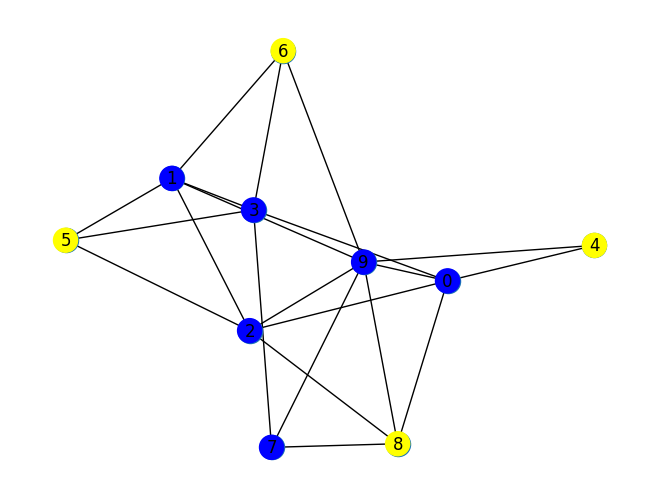

In [104]:
#this is the best bitstring found with the QAA algorithm
bitstring = found_best_bitstrings[-1]
#this is the networkx heuristic MIS solution
# bitstring = ind_set_bitstring
nx.draw(graph, pos = pos)
nx.draw_networkx_labels(graph, pos = pos);
node_colors = []
for i in range(len(graph)):
    if bitstring[i] == '0':
        node_colors.append('blue')
    elif bitstring[i] == '1':
        node_colors.append('yellow')
nx.draw_networkx_nodes(graph, pos=pos, node_color = node_colors)